# Battery Differential Analysis Pipeline – Borealis Dataset (Refactored)

This notebook is a **cleaned and refactored version** of the exploratory work (`explore_Borealis_dataset.ipynb`).  
It supports **batch processing** of the "03 - CONSTANT CURRENT" dataset from the Borealis project  
([DOI: 10.5683/SP3/UYPYDJ](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/UYPYDJ)).

---

## Purpose

The notebook implements a **modular pipeline** for:

- Parsing cycle-wise nested folder structures (each containing a single `.xlsx`)
- Identifying valid charge/discharge cycles based on segment length and voltage resolution
- Interpolating and smoothing capacity–voltage curves
- Selecting monotonic Q–V segments for differential analysis
- Computing and visualizing:
  - `dQ/dV` and `dV/dQ` from both raw and smoothed data
  - **Differential Coulometry Spectroscopy (DCS)** using current integration and smoothed voltage

This pipeline is intended as a reusable foundation for:

- Cell-level degradation diagnostics  
- Comparative method studies (`dV/dQ`, `dQ/dV`, `DCS`, and later `dP/dE`)
- Extension to automated multi-cycle and multi-cell workflows  
- Integration with external tools such as **PyProBE** and **PyBaMM**

---

## Usage Overview

- Use `select_valid_cycle(folder_no)` to explore and store valid cycles from a specific folder.
- Use `plot_selected_vq(...)` to visually inspect smoothed V–Q curves and manually determine a monotonic region.
- Use `plot_all_from_qrange(...)` to save and plot all relevant differential curves (raw, gradient, DCS) for a selected region.

All functions are designed to support interactive, reproducible exploration and batch extension.

---

## Notebook Structure

| Section | Title | Description |
|--------:|:------|:------------|
| **1** | Setup | Define global variables, paths, and column name aliases. Prepare folders for outputs. |
| **2** | File Mapping | Automatically detect `.xlsx` files in nested `Cycle XXXX` folders and build access map. |
| **3** | Data Loading and Segmentation | Load raw data, separate charge/discharge segments, and identify valid cycles. |
| **4** | Smoothing and Preprocessing | Apply interpolation, deduplication, and Savitzky–Golay smoothing for gradient-friendly V–Q curves. |
| **5** | Region Selection and Export | Manually select Q–V segments, save monotonic regions for analysis. |
| **6** | Differential Analysis | Generate and plot `dQ/dV`, `dV/dQ`, and DCS from raw, smoothed, or preprocessed segments. |
| **7** | Interactive Analysis Workflow | Example pipeline: load a folder, inspect a cycle, select a region, and visualize all differential outputs. |

---

> ⚠️ Region extraction using `save_monotonic_region_from_segment()` is **required** before running gradient or DCS analysis. These filtered segments ensure stable derivative computation and consistent comparisons across methods.


## Initialize Paths and Column Aliases

Define standard column names used in battery datasets and ensure required output folders exist for plots and processed data.


In [1]:
# Import dependencies
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

In [2]:
# Define standard column aliases
I = 'Current(A)'
V = 'Voltage(V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
dqdv = 'dQ/dV(Ah/V)'
dvdq = 'dV/dQ(V/Ah)'
T = 'Test_Time(s)'

In [3]:
# Set up output directories
current_dir = Path.cwd()

output_plot_path = current_dir.parent / 'Plots' / 'differential_curves'
output_data_path = current_dir.parent / 'Data' / 'monotonic_segments'
processed_data_path = current_dir.parent / 'Data' / 'processed_data'

# Create folders if they don't exist
output_plot_path.mkdir(parents=True, exist_ok=True)
output_data_path.mkdir(parents=True, exist_ok=True)
processed_data_path.mkdir(parents=True, exist_ok=True)

## Load and Map Raw Cycle Files

Scan the raw dataset folder and build a mapping from each cycle number to its corresponding `.xlsx` file.  
Assumes each folder is named `Cycle XXXX` and contains exactly one Excel file.

In [4]:
# Define base path to raw dataset
base_path = current_dir.parent / 'Data' / 'raw_data' / '03-CONSTANT CURRENT protocol_Cycles 0 to 1000'

# Build a mapping from cycle number to .xlsx file
cycle_file_map = {}

for folder_path in sorted(base_path.glob("Cycle *"), key=lambda p: int(p.name.split()[-1])):
    if folder_path.is_dir():
        folder_no = int(folder_path.name.replace("Cycle ", ""))
        xlsx_files = list(folder_path.glob("*.xlsx"))

        if not xlsx_files:
            print(f"[Warning] No .xlsx file found in {folder_path}")
            continue

        cycle_file_map[folder_no] = xlsx_files[0]

## Load, Smooth, and Segment Cycle Data

Includes utility functions to:
- Load a `.xlsx` file given a folder number.
- Apply Savitzky–Golay filtering to smooth voltage or other signal.
- Separate charge and discharge segments from raw cycle data.

In [5]:
def read(folder_no):
    """
    Load Excel file by folder number.

    Parameters:
        folder_no (int): e.g. 145 for 'Cycle 0145'

    Returns:
        pd.DataFrame: full dataframe from file
    """
    if folder_no not in cycle_file_map:
        raise ValueError(f"Folder {folder_no} not found in map.")
    return pd.read_excel(cycle_file_map[folder_no])

In [6]:
def smooth(df, col, window, polyorder, out_col='Voltage_sm (V)'):
    """
    Apply Savitzky-Golay filter to smooth a column.

    Parameters:
        df (pd.DataFrame): Input data
        col (str): Column to smooth
        window (int): Window size (must be odd)
        polyorder (int): Polynomial order
        out_col (str): Output column name

    Returns:
        pd.DataFrame: With new smoothed column added
    """
    df[out_col] = savgol_filter(df[col], window_length=window, polyorder=polyorder)
    return df

In [7]:
def separate_charge_discharge(cycle_df, cycle_no):
    """
    Separate charge and discharge segments from a cycle dataframe.

    Parameters:
        cycle_df (pd.DataFrame): Raw cycle data
        cycle_no (int): Cycle index (used for warnings)

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (charge_df, discharge_df)
    """
    # Filter charge segment
    charge_df = cycle_df[cycle_df[I] > 0].copy()
    charge_df = charge_df[[I, T, V, Qc, dvdq, dqdv]].dropna(subset=[I, T, V, Qc]).reset_index(drop=True)
    charge_df = charge_df[charge_df[Qc] > 0].reset_index(drop=True)

    # Filter discharge segment
    discharge_df = cycle_df[cycle_df[I] < 0].copy()
    discharge_df = discharge_df[[I, T, V, Qd, dvdq, dqdv]].dropna(subset=[I, T, V, Qd]).reset_index(drop=True)
    discharge_df = discharge_df[discharge_df[Qd] > 0].reset_index(drop=True)

    # Optional warnings
    if charge_df.empty:
        print(f"[Cycle {cycle_no}] Warning: No charge data found.")
    if discharge_df.empty:
        print(f"[Cycle {cycle_no}] Warning: No discharge data found.")

    return charge_df, discharge_df

## Identify Valid Charge/Discharge Segments

This function filters out cycles that are too short or have insufficient voltage resolution.
It uses segment length and voltage variation thresholds to select valid charge/discharge cycles.

Returns a DataFrame with metadata and segmented DataFrames for each accepted cycle.


In [8]:
def separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation):
    """
    Identify valid cycles based on minimum segment length and voltage variation.

    Parameters:
        df (pd.DataFrame): Full dataframe containing multiple cycles
        folder_no (int): Folder number where the data originated
        min_seg_length (int): Minimum number of rows for charge/discharge segment to be valid
        min_v_variation (int): Minimum number of unique voltage values required

    Returns:
        pd.DataFrame: Each row contains 'folder_no', 'cycle_no', 'charge_df', 'discharge_df'
    """
    valid_data = []

    for cycle_no, cycle_df in df.groupby("Cycle_Index"):
        charge_df, discharge_df = separate_charge_discharge(cycle_df, cycle_no)

        if (
            charge_df.empty or discharge_df.empty or
            len(charge_df) < min_seg_length or len(discharge_df) < min_seg_length or
            charge_df[V].nunique() < min_v_variation or discharge_df[V].nunique() < min_v_variation
        ):
            continue

        valid_data.append({
            "folder_no": folder_no,
            "cycle_no": cycle_no,
            "charge_df": charge_df,
            "discharge_df": discharge_df
        })

    return pd.DataFrame(valid_data)

## Load and Select Valid Cycle (Interactive Setup)

This section defines a global context (`_last_folder`) to store the currently selected folder and raw DataFrame.

Use `select_valid_cycle(folder_no)` to load a folder and list valid cycles for manual exploration or plotting.

In [9]:
# Global variable to store the last loaded folder's data
_last_folder = {
    'folder_no': None,
    'df': None
}

def select_valid_cycle(folder_no, min_seg_length=50, min_v_variation=10):
    """
    Load one folder, identify valid cycles, and store full dataframe for later use.
    Also prints valid cycle numbers for quick visual reference.

    Parameters:
        folder_no (int): Folder number to load
        min_seg_length (int): Minimum number of points in a valid segment
        min_v_variation (int): Minimum number of unique voltage values

    Returns:
        pd.DataFrame: Raw dataframe from the selected folder
    """
    df = read(folder_no)
    valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)

    print(f"[✓] Valid cycles in folder {folder_no}:")
    for c in valid_df['cycle_no'].unique():
        print(f"  - Cycle {c}")

    _last_folder['df'] = df
    _last_folder['folder_no'] = folder_no

    return df

## Smoothing and Preprocessing Methods

This section defines functions to:
- Smooth voltage curves using Savitzky–Golay filters.
- Preprocess capacity–voltage segments for gradient-based analysis.
- Handle interpolation, deduplication, and voltage smoothing consistently across charge/discharge.


In [10]:
def smooth_segment_for_gradient(df, q_col, window, polyorder):
    """
    Smooth voltage vs capacity while preserving dV/dQ and dQ/dV columns.
    Duplicate Q values are removed before sorting and smoothing.
    """
    df = df.copy()
    cols = [q_col, V, T, I, dvdq, dqdv]
    df = df[[col for col in cols if col in df.columns]]
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col).reset_index(drop=True)
    df["Voltage_sm (V)"] = savgol_filter(df[V].to_numpy(), window_length=window, polyorder=polyorder)
    return df

In [11]:
def smooth_segment_for_dcs(df, q_col, window, polyorder):
    """
    Smooth voltage without dropping duplicates (used in DCS).
    """
    df = df.copy()
    cols = [q_col, V, T, I, dvdq, dqdv]
    df = df[[col for col in cols if col in df.columns]]
    df = df.sort_values(by=q_col).reset_index(drop=True)
    df["Voltage_sm (V)"] = savgol_filter(df[V].to_numpy(), window_length=window, polyorder=polyorder)
    return df

In [12]:
def preprocess_segment(df, q_col, no_points, window, polyorder):
    """
    Interpolate and smooth voltage with respect to capacity.
    Other columns are truncated to shortest shared length.
    """
    x = df[q_col] - df[q_col].min()
    v, i, t = df[V], df[I], df[T]
    dVdQ, dQdV = df[dvdq], df[dqdv]

    x, v = map(np.array, (x, v))
    _, idx = np.unique(x, return_index=True)
    x, v = x[idx], v[idx]

    f_v = interpolate.interp1d(x, v, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x.min(), x.max(), no_points)
    q_interp = x.max() - z if q_col == Qd else z
    v_interp = f_v(z)

    min_len = min(len(q_interp), len(v_interp), len(t), len(i), len(dVdQ), len(dQdV))

    result = pd.DataFrame({
        T: t.tolist()[:min_len],
        I: i.tolist()[:min_len],
        q_col: q_interp[:min_len],
        "Interpolated Voltage (V)": v_interp[:min_len],
        dvdq: dVdQ.tolist()[:min_len],
        dqdv: dQdV.tolist()[:min_len]
    })

    return smooth(result, "Interpolated Voltage (V)", window, polyorder, out_col="Voltage_sm (V)")

## Batch Preprocessing Wrappers

Helper functions to apply smoothing or preprocessing to both charge/discharge
segments for a single cycle, or across all valid cycles in a folder.

In [13]:
def smooth_single_for_gradient(charge_df, discharge_df, window, polyorder):
    """
    Smooth both charge and discharge segments for gradient analysis.
    """
    c = smooth_segment_for_gradient(charge_df, Qc, window, polyorder)
    d = smooth_segment_for_gradient(discharge_df, Qd, window, polyorder)
    return c, d

In [14]:
def smooth_single_for_dcs(charge_df, discharge_df, window, polyorder):
    """
    Smooth both segments for DCS (keep all rows, no deduplication).
    """
    c = smooth_segment_for_dcs(charge_df, Qc, window, polyorder)
    d = smooth_segment_for_dcs(discharge_df, Qd, window, polyorder)
    return c, d

In [15]:
def preprocess_single(charge_df, discharge_df, no_points, window, polyorder):
    """
    Preprocess charge/discharge segments for one cycle.
    """
    c = preprocess_segment(charge_df, Qc, no_points, window, polyorder)
    d = preprocess_segment(discharge_df, Qd, no_points, window, polyorder)
    return c, d

In [16]:
def process_all(df, folder_no, min_seg_length, min_v_variation,
                no_points, window, polyorder, type='preprocess'):
    """
    Apply preprocessing or smoothing to all valid cycles in a folder.

    type: 'preprocess', 'smooth', or 'dcs'
    """
    processed = []
    valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)

    for _, row in valid_df.iterrows():
        if type == 'preprocess':
            c, d = preprocess_single(row["charge_df"], row["discharge_df"],
                                     no_points, window, polyorder)
        elif type == 'smooth':
            c, d = smooth_single_for_gradient(row["charge_df"], row["discharge_df"],
                                              window, polyorder)
        elif type == 'dcs':
            c, d = smooth_single_for_dcs(row["charge_df"], row["discharge_df"],
                                         window, polyorder)
        else:
            raise ValueError(f"Invalid type: {type}")

        processed.append({
            "folder_no": folder_no,
            "cycle_no": row["cycle_no"],
            "df_charge": c,
            "df_discharge": d
        })

    return processed

## Unified Plot Labels and Titles

Utility functions to standardize figure labels and titles across different types of differential plots.

In [17]:
def _make_title(kind, folder_no, cycle_no, process):
    return f"{kind} from Folder {folder_no}, Cycle {cycle_no} [{process}]"

def _make_label(kind):
    labels = {
        'dqdv_raw': 'Raw dQ/dV (from dataset)',
        'dvdq_raw': 'Raw dV/dQ (from dataset)',
        'dqdv_sm_grad': 'dQ/dV (gradient from smoothed V)',
        'dvdq_sm_grad': 'dV/dQ (gradient from smoothed V)',
        'dqdv_pre_grad': 'dQ/dV (gradient from interpolated + smoothed V)',
        'dvdq_pre_grad': 'dV/dQ (gradient from interpolated + smoothed V)',
        'dcs': 'DCS (dQ/dV from I·dt)',
        'vq': 'Smoothed V–Q curve'
    }
    return labels.get(kind, kind)

## Plot Preprocessed V–Q Curve

Plot the interpolated and smoothed voltage vs capacity curve for a specific processed cycle.
Returns the segment used for further analysis or saving.

In [18]:
def plot_preprocessed_qv(df, cycle_no, folder_no,
                         min_seg_length, min_v_variation,
                         no_points, window, polyorder,
                         process, **kwargs):
    processed = process_all(df, folder_no,
                            min_seg_length, min_v_variation,
                            no_points, window, polyorder,
                            type='preprocess')

    for entry in processed:
        if entry['cycle_no'] == cycle_no:
            df_pre = entry['df_charge'] if process == 'charge' else entry['df_discharge']
            q = df_pre[Qc] if process == 'charge' else df_pre[Qd]
            v = df_pre["Voltage_sm (V)"]
            break
    else:
        print(f"[Warning] Cycle {cycle_no} not found.")
        return None

    label = _make_label("vq")
    title = _make_title("Smoothed V–Q", folder_no, cycle_no, process)

    plt.plot(q, v, label=label, **kwargs)
    plt.xlabel("Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    return df_pre

## Save Monotonic Region

Save a selected Q-range segment from a processed or smoothed curve.
Supports multiple processing types including preprocessed, smoothed (gradient), and DCS.

In [19]:
def save_monotonic_region_from_segment(df, df_pre,
                                       folder_no, cycle_no, q_min, q_max,
                                       min_seg_length, min_v_variation,
                                       no_points, window, polyorder,
                                       process,
                                       type='smoothed'):
    q_col = Qc if process == 'charge' else Qd

    if type == 'preprocessed':
        region = df_pre[(df_pre[q_col] >= q_min) & (df_pre[q_col] <= q_max)].copy()
        name = f"preprocessed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"

    elif type == 'smoothed':
        df_smooth = process_all(df, folder_no,
                                min_seg_length, min_v_variation,
                                no_points, window, polyorder,
                                type='smooth')
        df_entry = next(item for item in df_smooth if item["cycle_no"] == cycle_no)
        df_seg = df_entry['df_charge'] if process == 'charge' else df_entry['df_discharge']
        region = df_seg[(df_seg[q_col] >= q_min) & (df_seg[q_col] <= q_max)].copy()
        name = f"smoothed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"

    elif type == 'dcs':
        valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)
        row = next(r for _, r in valid_df.iterrows() if r["cycle_no"] == cycle_no)
        raw_seg = row["charge_df"] if process == 'charge' else row["discharge_df"]
        df_seg = smooth_segment_for_dcs(raw_seg, q_col, window, polyorder)
        region = df_seg[(df_seg[q_col] >= q_min) & (df_seg[q_col] <= q_max)].copy()
        name = f"smoothed_for_dcs_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"

    else:
        raise ValueError(f"Invalid type: {type}")

    region.to_csv(output_data_path / name, index=False)
    print(f"[✓] Saved {type} region to {name}")

## Load Monotonic Segment

Load saved V–Q segments from file for plotting or further analysis.
Supports types: 'preprocessed', 'smoothed', 'dcs', 'raw'.

In [20]:
def get_mono(kind, folder_no, cycle_no, process):
    if kind == 'dcs':
        file_name = f"smoothed_for_dcs_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
    elif kind in ['preprocessed', 'smoothed']:
        file_name = f"{kind}_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
    else:
        raise ValueError("kind must be one of 'preprocessed', 'smoothed', or 'dcs'")

    full_path = output_data_path / file_name
    if not full_path.exists():
        raise FileNotFoundError(f"File not found: {full_path}")

    return pd.read_csv(full_path)

In [21]:
def load_mono_df(type, folder_no, cycle_no, process):
    valid_types = ['preprocessed', 'smoothed', 'dcs', 'raw']
    if type not in valid_types:
        raise ValueError(f"type must be one of {valid_types}")

    if type == 'dcs':
        file_name = f"smoothed_for_dcs_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
    else:
        file_name = f"{type}_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"

    path = output_data_path / file_name
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    return pd.read_csv(path)

## Plot Saved Monotonic Segment

Plot the smoothed V–Q curve for a pre-saved segment (from preprocessed data).

In [22]:
def plot_mono_pre_qv(folder_no, cycle_no, process, **kwargs):
    df = get_mono("preprocessed", folder_no, cycle_no, process)
    q = df[Qc] if process == 'charge' else df[Qd]
    v = df["Voltage_sm (V)"]
    label = kwargs.get('label', f"{process.capitalize()} V–Q (Cycle {cycle_no})")

    plt.plot(q, v, label=label, **kwargs)
    plt.xlabel("Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title(label)
    plt.grid(True)
    plt.legend()
    plt.show()

## Plot Raw Derivatives from Dataset

Plot dQ/dV and dV/dQ curves directly from raw dataset columns (no recomputation, no smoothing).


In [32]:
def plot_raw_derivative(df_dcs, folder_no, cycle_no, process, **kwargs):
    q_col = Qc if process == 'charge' else Qd
    df_base = df_dcs[[V, q_col, dvdq, dqdv]].dropna().reset_index(drop=True)

    # Drop 0s
    df_dqdv = df_base[df_base[dqdv] != 0]
    df_dvdq = df_base[df_base[dvdq] != 0]

    v1 = df_dqdv[V]
    dqdv_raw = df_dqdv[dqdv]

    v2 = df_dvdq[V]
    dvdq_raw = df_dvdq[dvdq]
    
    # Plot    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(v1, dqdv_raw, label=_make_label('dqdv_raw'), **kwargs)
    axes[0].set_xlabel("Voltage (V)")
    axes[0].set_ylabel("dQ/dV (Ah/V)")
    axes[0].set_title(_make_title('Raw dQ/dV', folder_no, cycle_no, process))
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(v2, dvdq_raw, label=_make_label('dvdq_raw'), **kwargs)
    axes[1].set_xlabel("Voltage (V)")
    axes[1].set_ylabel("dV/dQ (V/Ah)")
    axes[1].set_title(_make_title('Raw dV/dQ', folder_no, cycle_no, process))
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Compute and Plot Derivatives from Smoothed Curve

Use `np.gradient()` on smoothed V–Q data to compute and plot dQ/dV and dV/dQ.

In [24]:
def plot_sm_derivative(df_sm, folder_no, cycle_no, process, eps, save=True, **kwargs):
    q_col = Qc if process == 'charge' else Qd
    df = df_sm.copy()

    q = df[q_col].to_numpy()
    v = df['Voltage_sm (V)'].to_numpy()

    sort_idx = np.argsort(q)
    q, v = q[sort_idx], v[sort_idx]
    dq, dv = np.gradient(q), np.gradient(v)

    valid_dqdv = np.abs(dv) > eps
    valid_dvdq = np.abs(dq) > eps

    dqdv_vals = np.full_like(q, np.nan)
    dvdq_vals = np.full_like(q, np.nan)
    dqdv_vals[valid_dqdv] = dq[valid_dqdv] / dv[valid_dqdv]
    dvdq_vals[valid_dvdq] = dv[valid_dvdq] / dq[valid_dvdq]

    df[q_col], df['Voltage_sm (V)'] = q, v
    df['dQ/dV (computed from smoothed V) (Ah/V)'] = dqdv_vals
    df['dV/dQ (computed from smoothed V) (V/Ah)'] = dvdq_vals

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(v[valid_dqdv], dqdv_vals[valid_dqdv], label=_make_label('dqdv_sm_grad'), **kwargs)
    axes[1].plot(v[valid_dvdq], dvdq_vals[valid_dvdq], label=_make_label('dvdq_sm_grad'), **kwargs)

    for ax in axes:
        ax.set_xlabel("Voltage (V)")
        ax.grid(True)
        ax.legend()
    axes[0].set_ylabel("dQ/dV (Ah/V)")
    axes[1].set_ylabel("dV/dQ (V/Ah)")
    axes[0].set_title(_make_title('dQ/dV (gradient)', folder_no, cycle_no, process))
    axes[1].set_title(_make_title('dV/dQ (gradient)', folder_no, cycle_no, process))

    plt.tight_layout()
    plt.show()

    if save:
        file_name = f"smoothed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
        df.to_csv(output_data_path / file_name, index=False)
        print(f"[✓] Updated file saved with gradient columns: {file_name}")

    return df

## Compute and Plot Derivatives from Preprocessed Curve

Apply gradient computation to interpolated and smoothed preprocessed data.

In [25]:
def plot_pre_derivative(df_pre, folder_no, cycle_no, process, eps, save=True, **kwargs):
    q_col = Qc if process == 'charge' else Qd
    v = df_pre['Voltage_sm (V)'].to_numpy()
    q = df_pre[q_col].to_numpy()

    sort_idx = np.argsort(q)
    q, v = q[sort_idx], v[sort_idx]
    dq, dv = np.gradient(q), np.gradient(v)

    valid_dqdv = np.abs(dv) > eps
    valid_dvdq = np.abs(dq) > eps

    dqdv_vals = np.full_like(q, np.nan)
    dvdq_vals = np.full_like(q, np.nan)
    dqdv_vals[valid_dqdv] = dq[valid_dqdv] / dv[valid_dqdv]
    dvdq_vals[valid_dvdq] = dv[valid_dvdq] / dq[valid_dvdq]

    df_pre = df_pre.copy()
    df_pre[q_col], df_pre['Voltage_sm (V)'] = q, v
    df_pre['dQ/dV (computed from preprocessed V) (Ah/V)'] = dqdv_vals
    df_pre['dV/dQ (computed from preprocessed V) (V/Ah)'] = dvdq_vals

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(v[valid_dqdv], dqdv_vals[valid_dqdv], label=_make_label('dqdv_pre_grad'), **kwargs)
    axes[1].plot(v[valid_dvdq], dvdq_vals[valid_dvdq], label=_make_label('dvdq_pre_grad'), **kwargs)

    for ax in axes:
        ax.set_xlabel("Voltage (V)")
        ax.grid(True)
        ax.legend()
    axes[0].set_ylabel("dQ/dV (Ah/V)")
    axes[1].set_ylabel("dV/dQ (V/Ah)")
    axes[0].set_title(_make_title('dQ/dV (gradient)', folder_no, cycle_no, process))
    axes[1].set_title(_make_title('dV/dQ (gradient)', folder_no, cycle_no, process))

    plt.tight_layout()
    plt.show()

    if save:
        file_name = f"preprocessed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
        df_pre.to_csv(output_data_path / file_name, index=False)
        print(f"[✓] Saved preprocessed file with gradients: {file_name}")

    return df_pre

## Compute and Plot DCS (Differential Coulometry)

Integrate current to estimate charge, then compute dQ/dV vs voltage using smoothed voltage and np.gradient.

In [26]:
def compute_dcs_from_smoothed(df_dcs, eps):
    v = df_dcs['Voltage_sm (V)'].to_numpy()
    i = df_dcs[I].to_numpy()
    t = df_dcs[T].to_numpy() / 3600  # convert to hours

    dt = np.diff(t, prepend=t[0])
    q = np.cumsum(i * dt)

    dv = np.gradient(v)
    dq = np.gradient(q)

    mask = np.abs(dv) > eps
    v, dq, dv = v[mask], dq[mask], dv[mask]

    dqdv = dq / dv
    return v, dqdv


def plot_dcs_from_smoothed(df_dcs, folder_no, cycle_no, process, eps, save=True, **kwargs):
    v_dcs, dqdv_dcs = compute_dcs_from_smoothed(df_dcs, eps)
    dqdv_full = np.full(df_dcs.shape[0], np.nan)

    v_all = df_dcs['Voltage_sm (V)'].to_numpy()
    idx_map = np.isin(np.round(v_all, 5), np.round(v_dcs, 5))
    dqdv_full[idx_map] = dqdv_dcs

    df_sm = df_dcs.copy()
    df_sm['dQ/dV (DCS method) (Ah/V)'] = dqdv_full

    label = _make_label('dcs')
    title = _make_title(label, folder_no, cycle_no, process)

    plt.plot(v_dcs, dqdv_dcs, label=label, **kwargs)
    plt.xlabel("Voltage (V)")
    plt.ylabel("dQ/dV (Ah/V)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    if save:
        file_name = f"smoothed_for_dcs_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
        df_sm.to_csv(output_data_path / file_name, index=False)
        print(f"[✓] Updated file saved with DCS column: {file_name}")

    return df_sm

## Visual Selection of V–Q Region

Plot the preprocessed V–Q curve for a selected cycle, to help choose the appropriate Q-range (`q_min`, `q_max`) for differential analysis.

In [27]:
def plot_selected_vq(cycle_no, process='charge',
                     min_seg_length=50, min_v_variation=10,
                     no_points=300, window=11, polyorder=3,
                     **kwargs):
    """
    Plot preprocessed smoothed V–Q curve for a selected cycle.
    Useful for visually choosing the monotonic Q-range for later analysis.

    Uses _last_folder['df'] and _last_folder['folder_no'] as input source.
    """
    df = _last_folder['df']
    folder_no = _last_folder['folder_no']

    plot_preprocessed_qv(
        df=df,
        cycle_no=cycle_no,
        folder_no=folder_no,
        min_seg_length=min_seg_length,
        min_v_variation=min_v_variation,
        no_points=no_points,
        window=window,
        polyorder=polyorder,
        process=process,
        **kwargs
    )

## Full Differential Plot Pipeline (Single Cycle)

For a selected cycle:
1. Preprocess and plot the smoothed V–Q curve.
2. Extract and save monotonic regions for preprocessed, smoothed, and DCS segments.
3. Reload saved segments.
4. Plot all differential signals: raw, gradient-based, and DCS.

In [28]:
def plot_all_from_qrange(cycle_no, q_min, q_max, process,
                         min_seg_length, min_v_variation,
                         no_points, window, polyorder, eps,
                         **kwargs):
    """
    Complete differential analysis pipeline for a single cycle:
    - Plot V–Q curve
    - Save monotonic regions
    - Reload segments
    - Plot dQ/dV and dV/dQ from all methods
    """
    df = _last_folder['df']
    folder_no = _last_folder['folder_no']

    # Step 1: Plot V–Q curve and retrieve processed segment
    df_pre = plot_preprocessed_qv(
        df=df,
        cycle_no=cycle_no,
        folder_no=folder_no,
        min_seg_length=min_seg_length,
        min_v_variation=min_v_variation,
        no_points=no_points,
        window=window,
        polyorder=polyorder,
        process=process,
        **kwargs
    )

    # Step 2: Save Q-range regions from all 3 processing types
    for kind in ['preprocessed', 'smoothed', 'dcs']:
        save_monotonic_region_from_segment(
            df=df,
            df_pre=df_pre,
            folder_no=folder_no,
            cycle_no=cycle_no,
            q_min=q_min,
            q_max=q_max,
            min_seg_length=min_seg_length,
            min_v_variation=min_v_variation,
            no_points=no_points,
            window=window,
            polyorder=polyorder,
            process=process,
            type=kind
        )

    # Step 3: Reload saved segments
    df_pre_saved = get_mono('preprocessed', folder_no, cycle_no, process)
    df_sm_saved = get_mono('smoothed', folder_no, cycle_no, process)
    df_dcs_saved = get_mono('dcs', folder_no, cycle_no, process)

    # Step 4: Plot all differential signals
    plot_mono_pre_qv(folder_no, cycle_no, process, **kwargs)
    plot_raw_derivative(df_dcs_saved, folder_no, cycle_no, process, **kwargs)
    plot_pre_derivative(df_pre_saved, folder_no, cycle_no, process, eps=eps, **kwargs)
    plot_sm_derivative(df_sm_saved, folder_no, cycle_no, process, eps=eps, **kwargs)
    plot_dcs_from_smoothed(df_dcs_saved, folder_no, cycle_no, process, eps=eps, **kwargs)

## Example Analysis Workflow

This is a minimal working example demonstrating a typical V–Q and differential analysis workflow:

1. Load and inspect one folder.
2. Visually examine the smoothed V–Q curve.
3. Select a monotonic region and generate all differential plots.

In [29]:
select_valid_cycle(595)
# output: Valid cycles in folder (your choice): - Cycle 1, 2, 3, ...

[Cycle 2] Warning: No charge data found.
[Cycle 4] Warning: No charge data found.
[Cycle 6] Warning: No charge data found.
[Cycle 8] Warning: No charge data found.
[✓] Valid cycles in folder 595:
  - Cycle 1
  - Cycle 5
  - Cycle 9


,Data_Point,Date_Time,Test_Time(s),Step_Time(s),Cycle_Index,Step_Index,TC_Counter1,TC_Counter2,TC_Counter3,TC_Counter4,...,Aux_Temperature_5(C),Aux_dT/dt_5(C),Aux_Digital Output_1,Aux_Digital Output_2,Aux_Digital Output_3,Aux_Digital Output_4,Aux_Digital Output_5,Aux_Digital Output_6,Aux_Digital Output_7,Aux_Digital Output_8
0,1,08/25/2021 13:03:23.837,0.002,0.002,1,1,0,0,0,0,...,25.106,-0.20092,0,0,0,0,0,0,0,0
1,2,08/25/2021 13:03:23.846,0.011,0.002,1,2,0,0,0,0,...,25.106,-0.20092,0,0,0,0,0,0,0,0
2,3,08/25/2021 13:03:23.855,0.019,0.002,1,3,0,0,0,0,...,25.106,-0.20092,0,0,0,1,1,0,0,1
3,4,08/25/2021 13:03:23.863,0.027,0.002,1,4,0,0,0,0,...,25.106,-0.20092,0,0,0,1,1,0,0,1
4,5,08/25/2021 13:03:23.872,0.036,0.002,1,5,0,0,0,0,...,25.106,-0.20092,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297788,297789,08/31/2021 20:27:12.339,545028.503,2520.001,9,171,6,14,2,40,...,25.557,-0.01651,0,0,0,1,1,0,0,1
297789,297790,08/31/2021 20:28:12.338,545088.502,2580.000,9,171,6,14,2,40,...,25.393,-0.10313,0,0,0,1,1,0,0,1
297790,297791,08/31/2021 20:29:12.339,545148.503,2640.001,9,171,6,14,2,40,...,25.762,0.17046,0,0,0,1,1,0,0,1
297791,297792,08/31/2021 20:30:12.339,545208.503,2700.001,9,171,6,14,2,40,...,25.633,0.20871,0,0,0,1,1,0,0,1


[Cycle 2] Warning: No charge data found.
[Cycle 4] Warning: No charge data found.
[Cycle 6] Warning: No charge data found.
[Cycle 8] Warning: No charge data found.


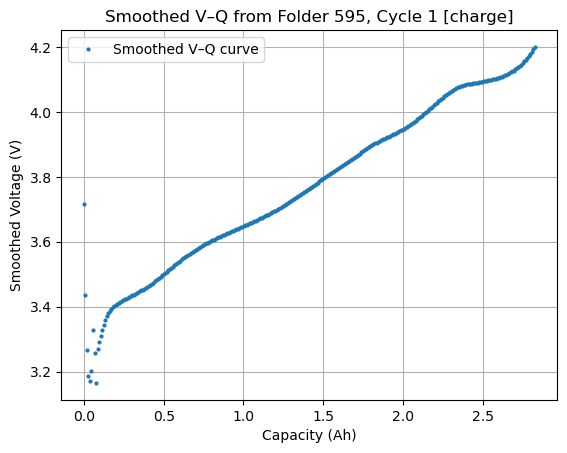

In [30]:
# Plot smoothed V–Q curve for Cycle no. (charge/discharge)
plot_selected_vq(
    cycle_no=1,
    process='charge',
    linestyle='none',
    marker='o',
    markersize=2
)

[Cycle 2] Warning: No charge data found.
[Cycle 4] Warning: No charge data found.
[Cycle 6] Warning: No charge data found.
[Cycle 8] Warning: No charge data found.


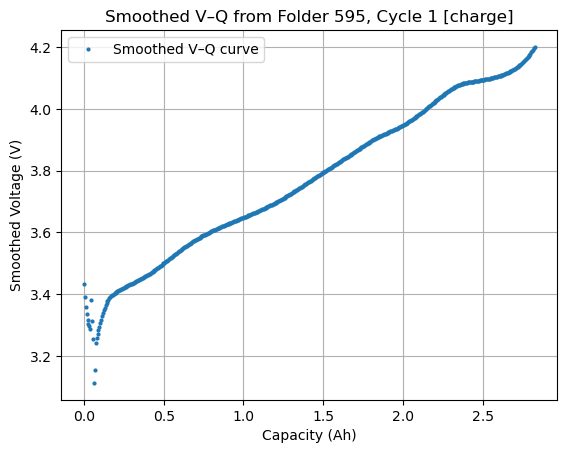

[✓] Saved preprocessed region to preprocessed_folder_0595_cycle_0001_charge.csv
[Cycle 2] Warning: No charge data found.
[Cycle 4] Warning: No charge data found.
[Cycle 6] Warning: No charge data found.
[Cycle 8] Warning: No charge data found.
[✓] Saved smoothed region to smoothed_folder_0595_cycle_0001_charge.csv
[Cycle 2] Warning: No charge data found.
[Cycle 4] Warning: No charge data found.
[Cycle 6] Warning: No charge data found.
[Cycle 8] Warning: No charge data found.
[✓] Saved dcs region to smoothed_for_dcs_folder_0595_cycle_0001_charge.csv


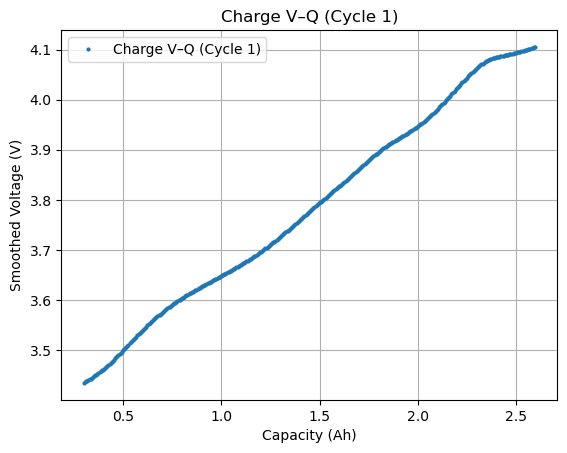

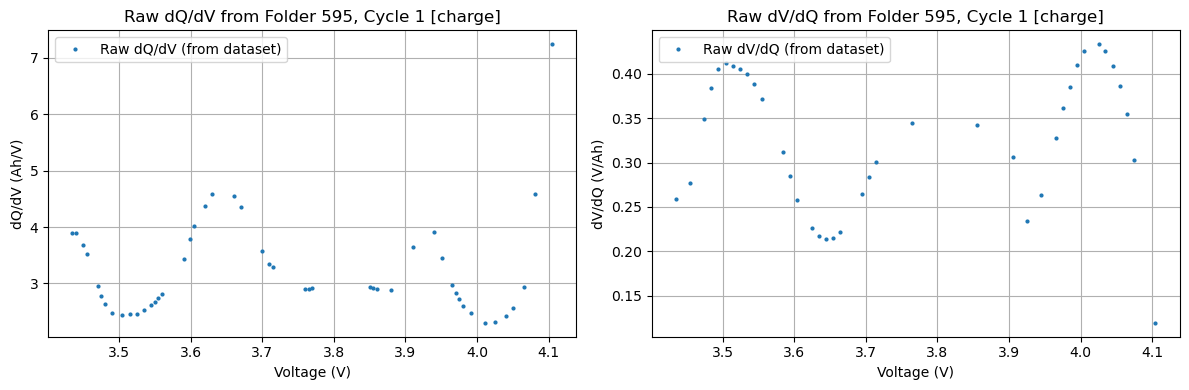

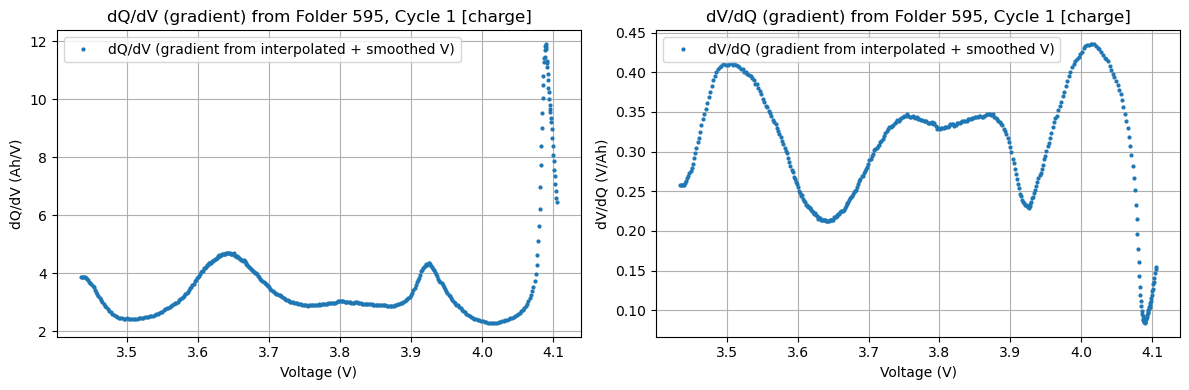

[✓] Saved preprocessed file with gradients: preprocessed_folder_0595_cycle_0001_charge.csv


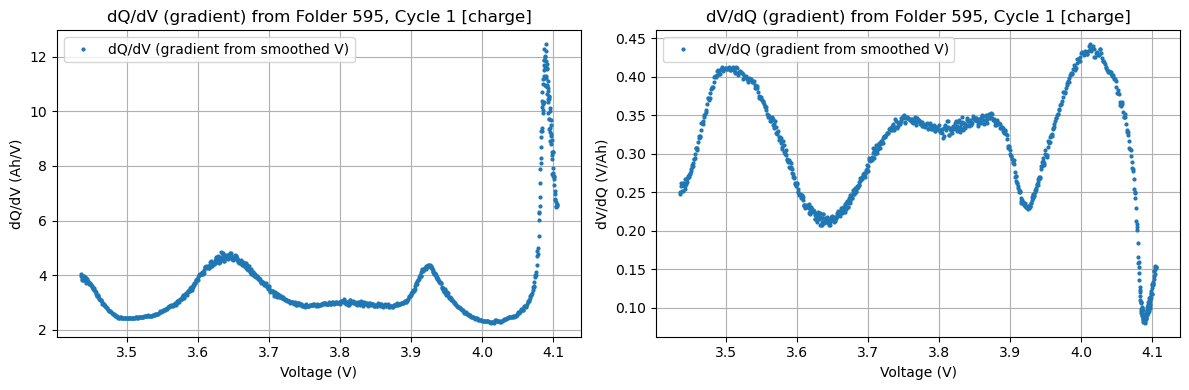

[✓] Updated file saved with gradient columns: smoothed_folder_0595_cycle_0001_charge.csv


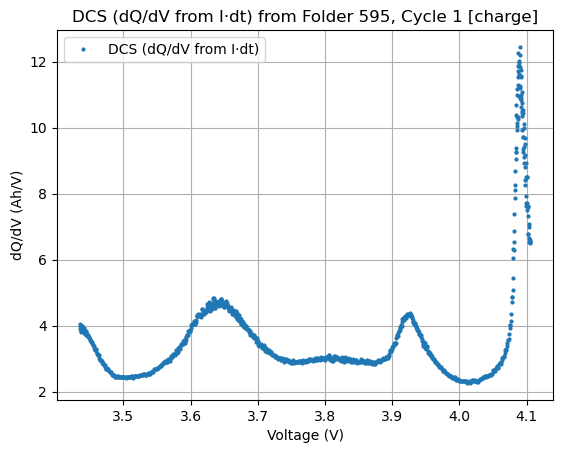

[✓] Updated file saved with DCS column: smoothed_for_dcs_folder_0595_cycle_0001_charge.csv


In [33]:
# Full pipeline: save region and plot all differential curves
plot_all_from_qrange(
    cycle_no=1,
    q_min=0.3,
    q_max=2.6,
    process='charge',

    min_seg_length=50,
    min_v_variation=10,
    no_points=500,
    window=15,
    polyorder=3,
    eps=1e-5,

    linestyle='none',
    marker='o',
    markersize=2
)